---
### Util.

In [1]:
import requests
from bs4 import BeautifulSoup
from IPython.display import HTML
import pyspark as ps
import pandas as pd
import numpy as np
import time

response_cache = {}

def http_get(url):
    if response := response_cache.get(url):
        return response
    else:
        response = requests.request(url=url, method="GET")
        counties_list_html = response.content
        response_cache[url] = counties_list_html
        
        return response_cache[url]

spark = (ps.sql.SparkSession
         .builder
         .master('local[8]')
         .appName('lecture')
         .getOrCreate())

sc = spark.sparkContext

In [2]:
def wikipedia_export_get(title):
    xml = http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    
    if b'<redirect title' in xml:
        return wikipedia_export_get(title=BeautifulSoup(xml).select('redirect')[0]['title'])
    else:
        return xml

def wikipedia_standard_url(title):
    return "https://en.wikipedia.org/wiki/" + title

def wikipedia_infobox_key_values(text):
    """
    {{Infobox settlement
    | name = Dooley
    | settlement_type = [[Ghost town]]
    | image_skyline = 
    | imagesize =
    | image_caption = 
    | pushpin_map = Montana#USA
    | pushpin_label_position = left
    | map_caption = Location of Dooley in Montana
    | coordinates_footnotes = <ref>{{cite gnis |id=770722 |name=Dooley}}</ref>
    | subdivision_type = [[List of sovereign states|Country]]
    | subdivision_name = United States
    | subdivision_type1 = [[U.S. state|State]]
    | subdivision_name1 = [[Montana]]
    | subdivision_type2 = [[List of counties in Montana|County]]
    | subdivision_name2 = [[Sheridan County, Montana|Sheridan]]
    | established_title = Established
    | established_date = 1913
    | named_for = 
    | extinct_title = Abandoned
    | extinct_date = 1957
    | elevation_ft = 2461
    | coordinates = {{coord|48|52|52|N|104|23|22|W|region:US-MT|display=inline,title}}
    }}
    """
    
    import re
    
    regex = r"^\s*\|\s*(.+?)\s*=(\s*|(\s*(.*)\s*))$"
    key_values = re.findall(regex, text, re.MULTILINE)

    return [(key, value) for key, _, _, value in key_values]

def wikipedia_infobox_key_values_non_empty(text):
    return [(key, value) for key, value in wikipedia_infobox_key_values(text) if value != '']

---

### Init!

In [3]:
!wc -l data/communities_all.txt
!wc -l data/communities_all_2.txt
!pip install folium

71208 data/communities_all.txt
22484 data/communities_all_2.txt
     |████████████████████████████████| 93 kB 571 kB/s eta 0:00:011


##### Split list of communities into smaller chunks to make bulk downloads easier
I had trouble doing a bulk download on the whole list.

In [ ]:
# example
cat communities_all.txt | awk 'NR >= 60001 && NR <= 90000 {print}' > communities--60_001--90_000.txt

##### From https://en.wikipedia.org/wiki/Special:Export/

In [4]:
%%time

filenames = ['data/communities--states.xml',
             'data/communities--00_001--30_000.xml',
             'data/communities--30_001--60_000.xml',
             'data/communities--60_001--90_000.xml']

pages_parsed = []
for filename in filenames:
    with open(filename) as f:
        parsed = BeautifulSoup(f.read())
        pages_parsed += parsed.select('mediawiki > page')
        
len(pages_parsed)

CPU times: user 3min 4s, sys: 10.3 s, total: 3min 15s
Wall time: 3min 18s


86886

##### Missing
Page doesn't exist, may be a redirect, not be made yet (was a red link), potential typos, etc.

In [5]:
titles_all = sc.textFile('data/communities_all.txt')
titles_parsed = [page.select('title')[0].getText().strip() for page in pages_parsed]

missing = list(set(titles_all.collect()).difference(titles_parsed))

##### Redirects
From missing, find those which are redirects

In [9]:
inner = []
for title in missing[:100]:
    is_redirect = b'<redirect title' in http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    inner.append(f'<div style="flex: reflow">(<b>{is_redirect if is_redirect else ""}</b><span style="color: gray">{is_redirect if not is_redirect else ""}</span>, </td><td><a href="{wikipedia_standard_url(title)}">{title}</a>)</div>')
    
HTML('<div style="display: flex; width: 100%; flex-flow: wrap">[' + ',&nbsp;'.join(inner) + ']</div>')

##### Patch Redirects

In [6]:
redirects = []

print("total", len(missing), "\n----")
for index, title in enumerate(missing):
    is_redirect = b'<redirect title' in http_get("https://en.wikipedia.org/wiki/Special:Export/" + title)
    
    if is_redirect:
        redirects.append(title)
        print(index, title)

total 6340 
----


KeyboardInterrupt: 

In [6]:
redirects = [
    'Prattsburgh (CDP), New York',
    'Jacobs, Ashland County, Wisconsin',
    'Gilmanton, Buffalo County, Wisconsin',
    'East Highland, Michigan',
    'Snyderville, Michigan',
    'Jones, Michigan',
    'Williamsburg, Tennessee',
    'Le Roy, Michigan',
    'Mount Helix, California',
    "Brown's Store, Ohio",
    'Loch Lomond, Florida',
    'Flom Township, Minnesota',
    'Mears, Michigan',
    'Bluff, UT',
    'Elyton, Alabama',
    'Mt. Olive, Oklahoma',
    'Shelby, Macomb County, Michigan',
    'Old Iron Town, Utah',
    'Hawks, Michigan',
    'Waimanalo, Hawaii',
    'Sherman City, Michigan',
    'Gros Cap, Michigan',
    'Fillmore, Michigan',
    'Canton (town), New York',
    'Manset, Maine',
    'Franklin, Venango County, Pennsylvania',
    'White River, Ashland County, Wisconsin',
    'Burr Oak Township, St. Joseph County, Michigan',
    'McVille, Armstrong County, Pennsylvania',
    'Cambridge (town), Vermont',
    'Orogrande, Idaho']

In [7]:
redirects_parsed = [BeautifulSoup(wikipedia_export_get(title)).select('page')[0] for title in redirects]
pages_parsed += redirects_parsed

In [1]:
'https://leaflet-extras.github.io/leaflet-providers/preview/'

'https://leaflet-extras.github.io/leaflet-providers/preview/'

##### Duplicates

In [8]:
titles_texts_all = {page.select('title')[0].getText(): page.select('text')[0].getText() for page in pages_parsed}
len(titles_texts_all)

68162

---
#### Analysis

In [ ]:
coordinates_texts_hashed = [(coordinate,
                            (set(''.join([c if c in "0123456789abcdefghijklmnopqrstuvwxyz'" else ' ' for c in text.lower()]).split()),
                             text,
                             dict(wikipedia_infobox_key_values_non_empty(text))),
                            title)
                            for coordinate, text, title in coordinates_texts_extracted]

[('Abbeville, Alabama', False),
 ('Adamsville, Alabama', False),
 ('Addison, Alabama', False),
 ('Akron, Alabama', False),
 ('Alabaster, Alabama', False),
 ('Albertville, Alabama', False),
 ('Alexander City, Alabama', False),
 ('Aliceville, Alabama', False),
 ('Allgood, Alabama', False),
 ('Altoona, Alabama', False),
 ('Andalusia, Alabama', False),
 ('Anniston, Alabama', False),
 ('Arab, Alabama', False),
 ('Ardmore, Alabama', False),
 ('Argo, Alabama', False),
 ('Ariton, Alabama', False),
 ('Arley, Alabama', False),
 ('Ashford, Alabama', False),
 ('Ashland, Alabama', False),
 ('Ashville, Alabama', False)]

In [183]:
coordinates_tokencounts_texts_infos = [(coordinate, 
                                         (collections.Counter(''.join([c if c in "0123456789abcdefghijklmnopqrstuvwxyz'" else ' ' for c in text_raw.lower()]).split()),
                                          text_raw,
                                          infobox_dict),
                                        title)
                                  for coordinate, (tokens_set, text_raw, infobox_dict), title in coordinates_texts_hashed]

In [1106]:
import pandas as pd
import collections

def is_ghost_town(infobox_dict):
    settlement_type = infobox_dict.get('settlement_type', '').lower()
    return 'ghost' in settlement_type or 'former' in settlement_type

def mining(counts):
    return counts['mine'] + counts['mining'] + counts['gold']

def logging(counts):
    return counts['logging'] + counts['mill'] + counts['sawmill'] + counts['mills'] + counts['sawmills']

def oil(counts):
    return counts['oil'] + counts['well'] + counts['wells']

def fire(counts):
    return counts['fire'] + counts['fires']

def earthquake(counts):
    return counts['earthquake'] + counts['earthquakes']

def flood(counts):
    return counts['flood'] + counts['floods']

def scary_wind(counts):
    return counts['tornado'] + counts['tornados'] + counts['hurricane'] + counts['hurricanes']

def population(infobox_dict):
    try:
        return float(infobox_dict.get('population_total'))
    except:
        return float('nan')

rows = [(title,
         is_ghost_town(infobox_dict), population(infobox_dict),
         oil(counts), mining(counts), logging(counts), counts['farming'],
         
         fire(counts), earthquake(counts), flood(counts), scary_wind(counts),
         counts['railroad'],
         sum(counts.values()),
         counts['sex'], counts['drugs'], np.sqrt(counts['rock'] * counts['roll']),
         counts['videogames'], np.sqrt(counts['civil'] * counts['war'])
        )

        for coordinate, (counts, text_raw, infobox_dict), title in coordinates_tokencounts_texts_infos[:4000]]

df = pd.DataFrame([row[1:] for row in rows], index=[row[0] for row in rows])
df.columns = ['Is Ghost Town', 'Population',
              'Oil', 'Mining', 'Logging', 'Farming',
              'Fire', 'Earthquake', 'Flood', 'Tornados', 'Railroad',
              'Token Counts', 'Sex', 'Drugs', 'Rock & Roll', 'Videogames', 'Civil War']
df[(df['Is Ghost Town'] == True) & (df['Oil'] + df['Mining'] + df['Logging'] > 0)]

,Is Ghost Town,Population,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,Railroad,Token Counts,Sex,Drugs,Rock & Roll,Videogames,Civil War
"Beaver Mills, Alabama",True,NaN,0,0,5,0,0,0,0,0,1,444,0,0,0.0,0,1.0
"Kaulton, Alabama",True,NaN,0,1,4,0,0,0,0,0,0,831,0,0,0.0,0,0.0
"Adamsville, Arizona",True,NaN,0,0,2,0,0,0,1,0,0,1129,0,0,0.0,0,0.0
"Alamo Crossing, Arizona",True,NaN,0,16,1,0,0,0,1,0,0,1682,0,0,0.0,0,0.0
"Alexandra, Arizona",True,0.0,0,8,2,0,0,0,0,0,0,613,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Brookhaven, Georgia",True,40456.0,6,2,1,0,1,0,0,0,0,7470,0,0,0.0,0,0.0
"Burke, Idaho",True,NaN,0,45,4,0,4,0,1,0,10,3917,0,0,0.0,0,0.0
"Florence, Idaho",True,NaN,1,16,2,0,0,0,0,0,0,2064,0,0,0.0,0,0.0
"Mount Idaho, Idaho",True,NaN,0,2,0,0,0,0,0,0,0,640,0,0,0.0,0,0.0


In [1053]:
rs = df['Mining'] > 0
rs

Abbeville, Alabama        False
Adamsville, Alabama        True
Addison, Alabama          False
Akron, Alabama            False
Alabaster, Alabama         True
                          ...  
Canton, Illinois           True
Cantrall, Illinois        False
Capron, Illinois          False
Carbon Cliff, Illinois     True
Carbon Hill, Illinois     False
Name: Mining, Length: 4000, dtype: bool

In [1054]:
totals = df.groupby('Is Ghost Town').sum()
totals = totals.reset_index()

naughts = totals[~totals['Is Ghost Town']]
yays = totals[totals['Is Ghost Town']]
naughts.merge(yays, how='outer')

,Is Ghost Town,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,Railroad,Token Counts,Sex,Drugs,Rock & Roll,Videogames,Civil War
0,False,3917,3778,1984,411,3509,762,493,1525,4212,10934455,1989,21,92.628478,1,1896.474043
1,True,117,938,153,14,32,17,10,4,198,154044,0,0,0.000000,0,32.392616


In [1057]:
totals = df.groupby('Is Ghost Town').sum()
totals = totals.reset_index()

naughts = totals[~totals['Is Ghost Town']] / totals['Token Counts'][~totals['Is Ghost Town']].iloc[0]
yays = totals[totals['Is Ghost Town']] / totals['Token Counts'][totals['Is Ghost Town']].iloc[0]
token_normalized = naughts.merge(yays, how='outer')
token_normalized['Is Ghost Town'] = [False, True]
totals

,Is Ghost Town,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,Railroad,Token Counts,Sex,Drugs,Rock & Roll,Videogames,Civil War
0,False,3917,3778,1984,411,3509,762,493,1525,4212,10934455,1989,21,92.628478,1,1896.474043
1,True,117,938,153,14,32,17,10,4,198,154044,0,0,0.000000,0,32.392616


In [1138]:
small_pop = df[(df['Population'] == float('nan')) | (df['Population'] < 1000)]

small_pop = small_pop.groupby('Is Ghost Town').sum()
small_pop = small_pop.reset_index()
totals = small_pop

naughts = totals[~totals['Is Ghost Town']] / totals['Token Counts'][~totals['Is Ghost Town']].iloc[0]
yays = totals[totals['Is Ghost Town']] / totals['Token Counts'][totals['Is Ghost Town']].iloc[0]
token_normalized = naughts.merge(yays, how='outer')
token_normalized['Is Ghost Town'] = [False, True]

token_normalized = token_normalized.drop(['Population'], axis=1)

token_normalized

,Is Ghost Town,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,Railroad,Token Counts,Sex,Drugs,Rock & Roll,Videogames,Civil War
0,False,0.000166,0.000418,0.000120,0.000026,0.000152,0.000026,0.000019,0.000037,0.000308,1.0,0.000037,4.639448e-07,0.0,0.0,0.000075
1,True,0.000599,0.007714,0.001463,0.000100,0.000166,0.000233,0.000067,0.000000,0.001330,1.0,0.000000,0.000000e+00,0.0,0.0,0.000191


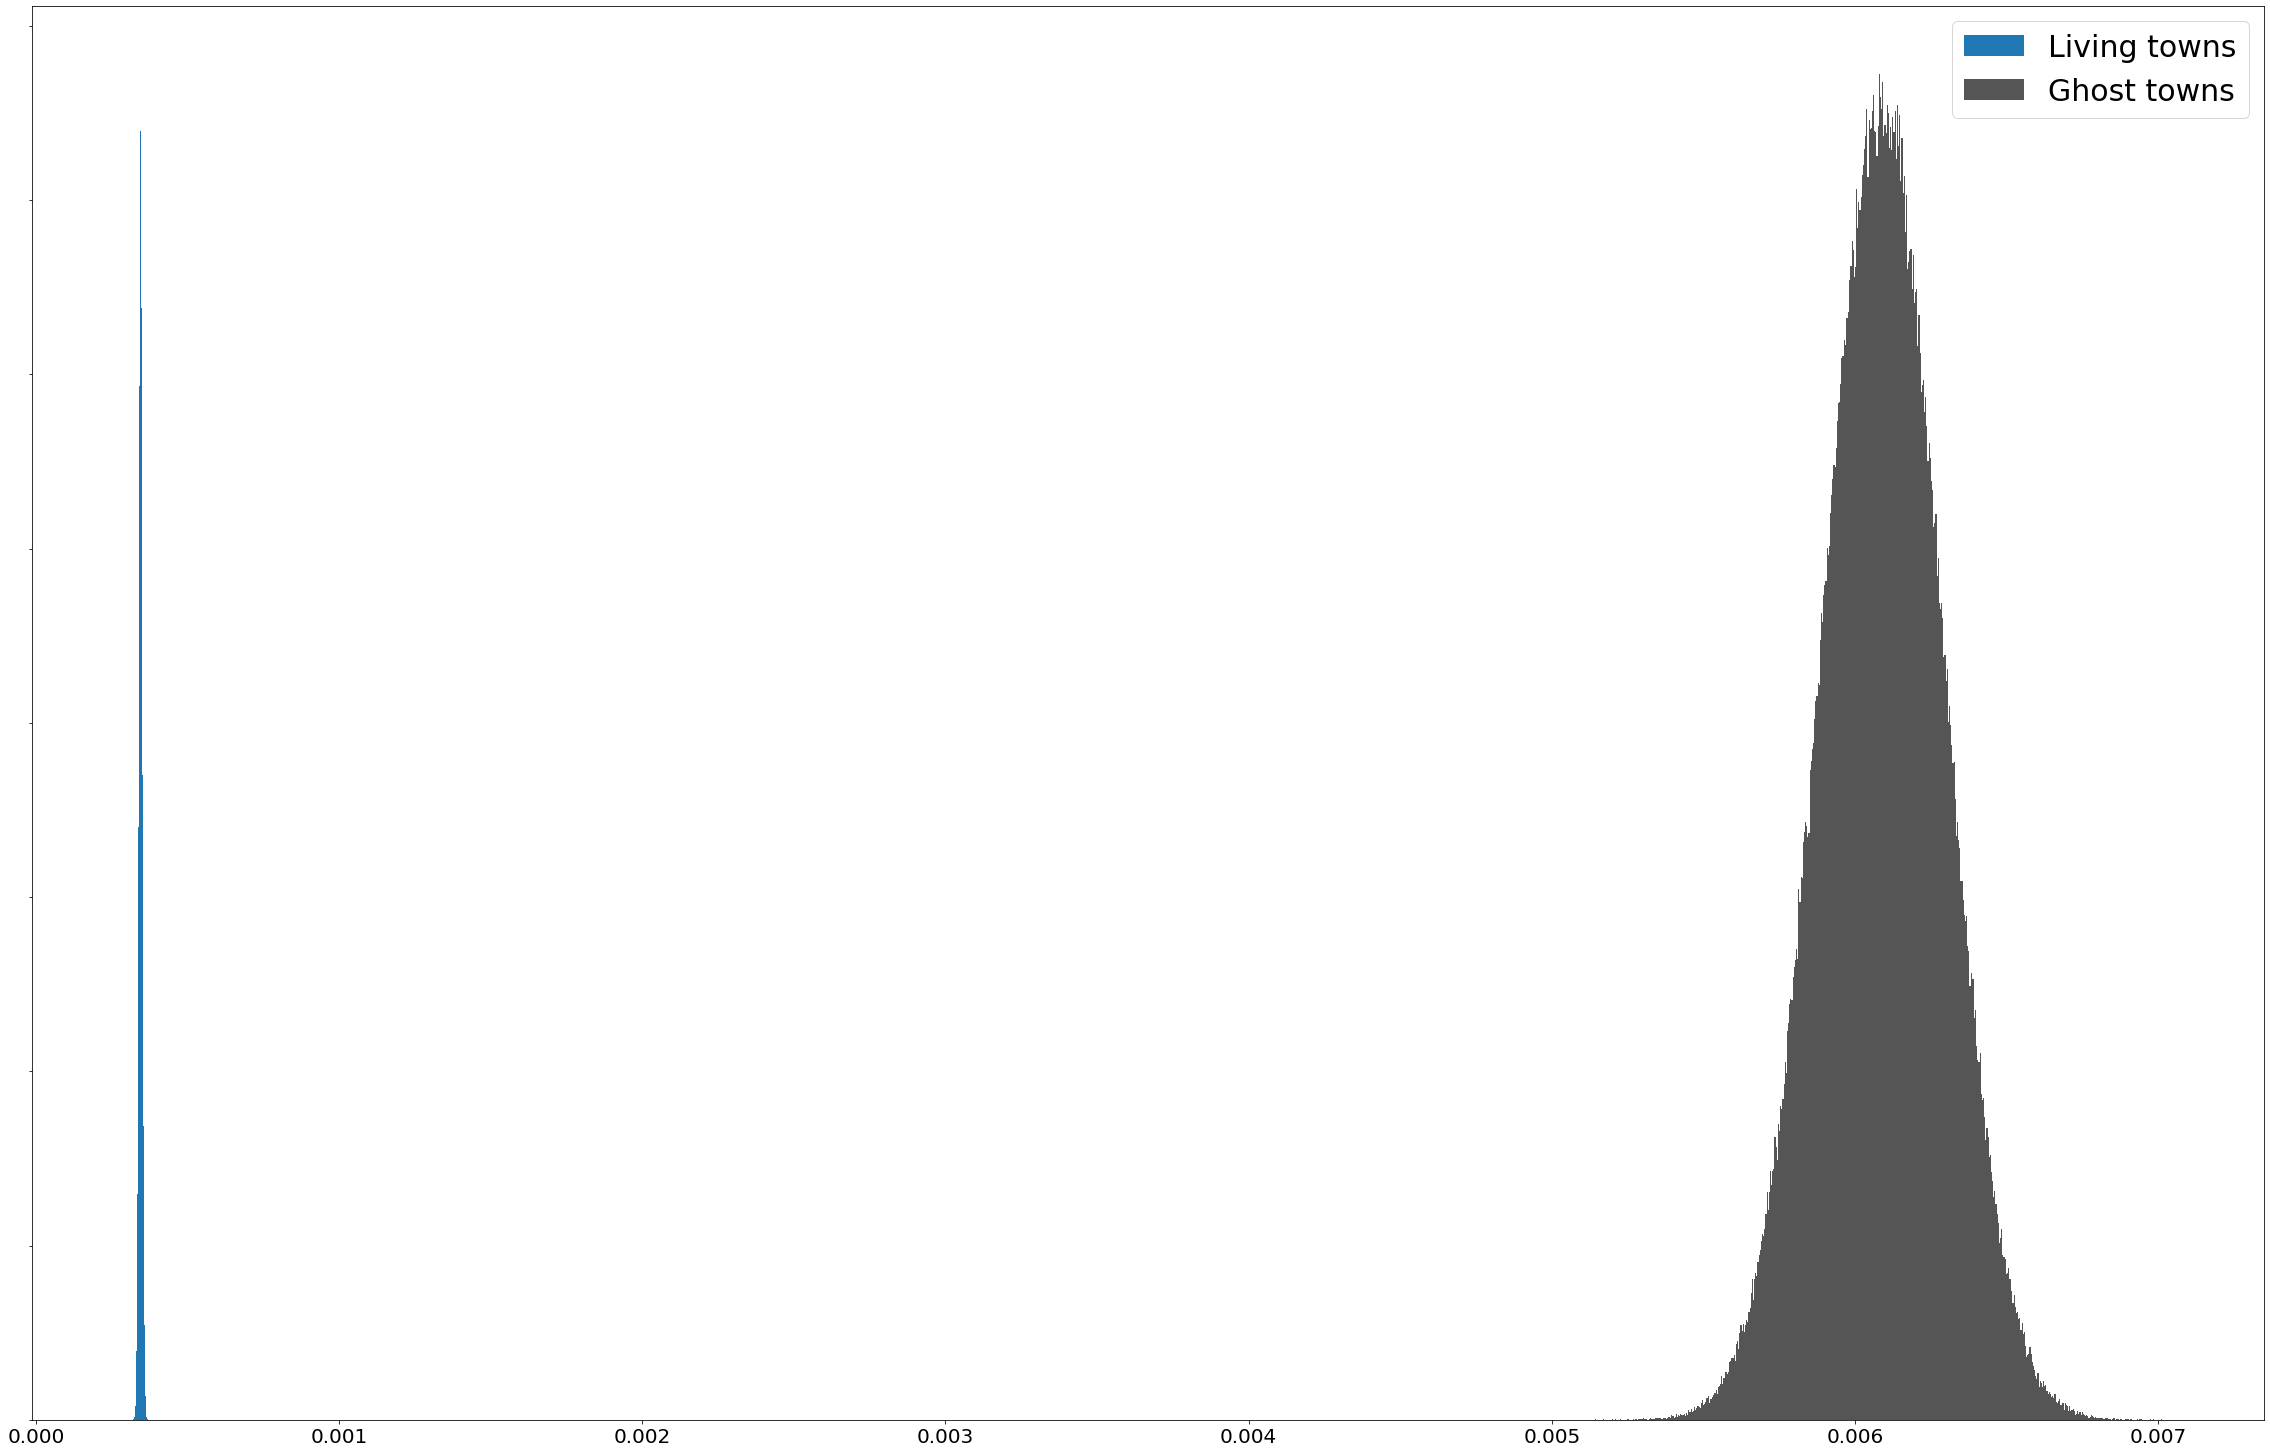

In [1100]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

townsL = totals['Token Counts'].iloc[0]
pL = token_normalized['Mining'][0]
stdL = np.sqrt(pL*(1-pL)/townsL)
distL = stats.norm(loc=pL, scale=stdL)

townsG = totals['Token Counts'].iloc[1]
pG = token_normalized['Mining'][1]
stdG = np.sqrt(pG*(1-pG)/townsG)
distG = stats.norm(loc=pG, scale=stdG)

stdH0 = np.sqrt(pL*(1-pL)/townsL + pG*(1-pG)/townsG)
pShared = (pL*townsL + pG*townsG)/(townsL + townsG)
stdH0 = np.sqrt(pShared*(1-pShared)/townsL + pShared*(1-pShared)/townsG)
distH0 = stats.norm(loc=0, scale=stdH0)

fig, ax = plt.subplots(figsize=(2*20, 2*13))

hist = True
if hist:
    num_samples = 500000
    ax.hist(distL.rvs(num_samples), bins=500, label="Living towns");
    ax.hist(distG.rvs(num_samples), bins=500, label="Ghost towns", color='#555');
    # ax.hist(distH0.rvs(num_samples), bins=500);
    plt.legend(fontsize=30, loc='upper right')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=0, color='none')

if not hist:
    xs = np.linspace(-0.0003, .007, 50000)
    ax.plot(xs, distL.pdf(xs))
    ax.plot(xs, distG.pdf(xs))
    ax.plot(xs, distH0.pdf(xs))

In [405]:
pG

0.0060891693282438784

In [988]:
1 - distH0.cdf(pG-pL)

0.0

In [1051]:
import pandas as pd
import collections

def is_ghost_town(infobox_dict):
    settlement_type = infobox_dict.get('settlement_type', '').lower()
    return 'ghost' in settlement_type or 'former' in settlement_type

def mining(counts):
    return (counts['mine'] + counts['mining'] + counts['gold']) / sum(counts.values())

def logging(counts):
    return (counts['logging'] + counts['mill'] + counts['sawmill'] + counts['mills'] + counts['sawmills']) / sum(counts.values())

def oil(counts):
    return (counts['oil'] + counts['well'] + counts['wells']) / sum(counts.values())

def fire(counts):
    return (counts['fire'] + counts['fires']) / sum(counts.values())

def earthquake(counts):
    return (counts['earthquake'] + counts['earthquakes']) / sum(counts.values())

def flood(counts):
    return (counts['flood'] + counts['floods']) / sum(counts.values())

def scary_wind(counts):
    return (counts['tornado'] + counts['tornados'] + counts['hurricane'] + counts['hurricanes']) / sum(counts.values())

rows = [(title,
         is_ghost_town(infobox_dict),
         oil(counts), mining(counts), logging(counts),
         (counts['farming']) / sum(counts.values()),
         fire(counts), earthquake(counts), flood(counts), scary_wind(counts),
         sum(counts.values()),
         counts['sex'] / sum(counts.values()),
         counts['drugs'] / sum(counts.values()),
         (counts['rock'] * counts['roll']) / sum(counts.values()),
         (counts['videogames']) / sum(counts.values())
         # alcohol(token_counts)
        )

        for coordinate, (counts, text_raw, infobox_dict), title in coordinates_tokencounts_texts_infos]

df = pd.DataFrame([row[1:] for row in rows], index=[row[0] for row in rows])
df.columns = ['Is Ghost Town', 'Oil', 'Mining', 'Logging', 'Farming', 'Fire', 'Earthquake', 'Flood', 'Tornados',
              'Token Counts', 'Sex', 'Drugs', 'Rock & Roll', 'Videogames']
df[(df['Is Ghost Town'] == True) & (df['Oil'] + df['Mining'] + df['Logging'] > 0)]

,Is Ghost Town,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,Token Counts,Sex,Drugs,Rock & Roll,Videogames
"Beaver Mills, Alabama",True,0.000000,0.000000,0.011261,0.0,0.0,0.0,0.000000,0.000000,444,0.0,0.0,0.0,0.0
"Kaulton, Alabama",True,0.000000,0.001203,0.004813,0.0,0.0,0.0,0.000000,0.000000,831,0.0,0.0,0.0,0.0
"Adamsville, Arizona",True,0.000000,0.000000,0.001771,0.0,0.0,0.0,0.000886,0.000000,1129,0.0,0.0,0.0,0.0
"Alamo Crossing, Arizona",True,0.000000,0.009512,0.000595,0.0,0.0,0.0,0.000595,0.000000,1682,0.0,0.0,0.0,0.0
"Alexandra, Arizona",True,0.000000,0.013051,0.003263,0.0,0.0,0.0,0.000000,0.000000,613,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Mandan, Michigan",True,0.000000,0.007082,0.000000,0.0,0.0,0.0,0.000000,0.000000,706,0.0,0.0,0.0,0.0
"Vegas Creek, Nevada",True,0.001441,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,694,0.0,0.0,0.0,0.0
"Plum Grove, Kansas",True,0.001307,0.000000,0.002614,0.0,0.0,0.0,0.000000,0.000000,1530,0.0,0.0,0.0,0.0
"Blockley Township, Pennsylvania",True,0.000000,0.000000,0.002506,0.0,0.0,0.0,0.000000,0.000000,798,0.0,0.0,0.0,0.0


In [1050]:
totals = df.groupby('Is Ghost Town').sum()
totals = totals.reset_index()

naughts = totals[~totals['Is Ghost Town']] / sum(~df['Is Ghost Town'])
yays = totals[totals['Is Ghost Town']] / sum(df['Is Ghost Town'])
naughts.merge(yays, how='outer')

,Is Ghost Town,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,GOLD,Token Counts,Sex,Drugs,Rock & Roll,Videogames
0,0.000000,0.000158,0.000149,0.000241,0.000025,0.000143,0.000009,0.000023,0.000058,0.267094,1476.739965,6.101020e-05,9.890324e-07,0.000005,9.444167e-09
1,0.000938,0.000401,0.002415,0.000690,0.000074,0.000164,0.000028,0.000077,0.000054,2.301126,750.611632,3.949837e-07,0.000000e+00,0.000000,0.000000e+00


In [272]:
df.groupby('Is Ghost Town').sum()

,Oil,Mining,Logging,Farming,Fire,Earthquake,Flood,Tornados,GOLD,Token Counts,Sex,Drugs,Rock & Roll,Videogames
Is Ghost Town,,,,,,,,,,,,,,
False,0.901477,1.445416,0.606322,0.129558,0.779944,0.133411,0.117941,0.389080,3778,10934455,0.457186,0.003911,0.037166,0.000118
True,0.090526,0.971977,0.143750,0.013799,0.026018,0.009367,0.007907,0.006487,938,154044,0.000000,0.000000,0.000000,0.000000


In [1049]:
len(df['Is Ghost Town'] == True), sum(df['Is Ghost Town'] == True), sum(~df['Is Ghost Town'])

(54901, 1066, 53835)

---
#### Geography

In [9]:
def coordinate_normalize(N, W):
    degrees_N, minutes_N, seconds_N = N
    degrees_W, minutes_W, seconds_W = W
    
    return (degrees_N + minutes_N / 60 + seconds_N / 3600,
            degrees_W + minutes_W / 60 + seconds_W / 3600)

def infobox_coordinate_extract(coordinate_text):
    import re
    
    regex = r"{{coord\|(.+?)\|(.+?)\|(.+?)\|N\|(.+?)\|(.+?)\|(.+?)\|W(?:\|.+)?"
    results = re.findall(regex, coordinate_text, re.IGNORECASE)

    if results != []:
        # print(results)
        dn, mn, sn, dw, mw, sw = [float(num) for num in results[0]]
        coordinate = coordinate_normalize(N=(dn, mn, sn), W=(-dw, -mw, -sw))
        return coordinate
    else:
        regex = r"{{coord\|(.+?)\|(.+?)\|N\|(.+?)\|(.+?)\|W(?:\|.+)?"
        results = re.findall(regex, coordinate_text, re.IGNORECASE)
        
    if results != [] and '|' not in results[0]:
        dn, mn, dw, mw = [float(num) for num in results[0]]
        coordinate = coordinate_normalize(N=(dn, mn, 0), W=(-dw, -mw, 0))
        
        return coordinate
    else:
        regex = r"{{coord\|(.+?)\|+N\|(.+?)\|+W(?:\|.+)?"
        results = re.findall(regex, coordinate_text, re.IGNORECASE)
        
    if results != []:
        dn, dw = [float(num) for num in results[0]]
        coordinate = coordinate_normalize(N=(dn, 0, 0), W=(-dw, 0, 0))
    else:
        regex = r"{{coord\|(.+?)\|([.\-0-9]+)"
        results = re.findall(regex, coordinate_text, re.IGNORECASE)
        
    if results != []:
        dn, dw = [float(num) for num in results[0]]
        coordinate = coordinate_normalize(N=(dn, 0, 0), W=(dw, 0, 0))
        
        return coordinate
    else:
        return []

In [13]:
titles_texts_infoboxes = [(title, text, {key: value for key, value in wikipedia_infobox_key_values_non_empty(text) if 'co' in key})
                          for title, text in titles_texts_all.items()]

titles_texts_infoboxes = [triple for triple in titles_texts_infoboxes if triple[2] != {}]

coordinates_texts_titles = [(dict_['coordinates'], text, title) for title, text, dict_ in titles_texts_infoboxes
                            if dict_.get('coordinates', None) != None]

In [14]:
coordinates_texts_extracted = [(infobox_coordinate_extract(coordinate), text, title)
                               for coordinate, text, title in coordinates_texts_titles
                               if infobox_coordinate_extract(coordinate) != []]

##### Keys

In [30]:
infoboxes_keyvalues_all = [wikipedia_infobox_key_values_non_empty(text) for title, text in titles_texts_all.items()]

In [17]:
all_keys = {}

for title, text in titles_texts_all.items():
    for key, value in wikipedia_infobox_key_values_non_empty(text):
        all_keys[key] = all_keys.get(key, 0) + 1

In [1016]:
[kv for kv in sorted(all_keys.items(), key=lambda x: -x[1]) if 'imag' in kv[0]]

[('image_map', 34665),
 ('image_skyline', 21922),
 ('image_caption', 19974),
 ('imagesize', 8838),
 ('image_map1', 7413),
 ('image_seal', 3106),
 ('image_flag', 637),
 ('pushpin_image', 514),
 ('image', 463),
 ('image_blank_emblem', 273),
 ('image2', 232),
 ('image1', 216),
 ('image_alt', 134),
 ('image_size', 118),
 ('image3', 77),
 ('ex image', 57),
 ('ex image cap', 55),
 ('image4', 42),
 ('image_shield', 29),
 ('image5', 21),
 ('ex image size', 21),
 ('image6', 15),
 ('image_style', 11),
 ('image7', 10),
 ('image-width', 6),
 ('image_map_size', 6),
 ('image8', 5),
 ('image-left', 4),
 ('image-top', 4),
 ('image_dot_map', 3),
 ('|image_caption', 3),
 ('image_logo', 3),
 ('image_map_caption', 3),
 ('{{Panorama |image', 3),
 ('image_name', 2),
 ('image_upright', 2),
 ('image_seal                Fox 16', 1),
 ('image-bg-color', 1),
 ('|image_map', 1),
 ('image_captionq', 1),
 ('image_caption            F', 1),
 ('image_branstrompark', 1),
 ('image_map2', 1),
 ('image_seal_size', 1),
 (

In [32]:
%%time

coordinates_texts_hashed = [(coordinate,
                            (set(''.join([c if c in "0123456789abcdefghijklmnopqrstuvwxyz'" else ' ' for c in text.lower()]).split()),
                             text,
                             dict(wikipedia_infobox_key_values_non_empty(text))),
                            title)
                            for coordinate, text, title in coordinates_texts_extracted]

CPU times: user 1min 31s, sys: 2.84 s, total: 1min 34s
Wall time: 1min 34s


In [29]:
coordinates_texts_hashed[21577][1]

({"'''mount",
  '0',
  '1',
  '10',
  '103',
  '1181684',
  '155',
  '1600000us4251552',
  '17',
  '175px',
  '2010',
  '2010census',
  '2015',
  '20150417175127',
  '220',
  '250x200px',
  '29',
  '4',
  '40',
  '42',
  '49',
  '5',
  '51552',
  '58',
  '66',
  '690',
  '77',
  '9',
  'a',
  'access',
  'accessdate',
  'along',
  'american',
  'an',
  'and',
  'april',
  'archive',
  'area',
  'as',
  'authority',
  'bald',
  'bkmk',
  'blank',
  'blank1',
  'boggs',
  'borough',
  'branch',
  'bureau',
  'but',
  'by',
  'caption',
  'caption1',
  'category',
  'cdp',
  'census',
  'centre',
  'cite',
  'city',
  'code',
  'codes',
  'community',
  'control',
  'convert',
  'coord',
  'coordinates',
  'corner',
  'counties',
  'country',
  'county',
  'creek',
  'date',
  'dead',
  'dec',
  'density',
  'designated',
  'display',
  'distance',
  'dst',
  'eagle',
  "eagle'''",
  'eastern',
  'edt',
  'elevation',
  'en',
  'ends',
  'est',
  'established',
  'factfinder',
  'feature'

In [1156]:
# export
import re

export_data = []
for coordinate, (text_tokenized, text_raw, infobox_dict_), title in coordinates_texts_hashed:
    if date := infobox_dict_.get('established_date'):
        regex = r"\d\d\d\d"
        if matches := re.findall(regex, date):
            # print(coordinate, matches[0])
            export_data.append([list(coordinate), matches[0]])
        

In [1158]:
import json

with open('data/coordinates_dates.json', 'w') as file:
    file.write(json.dumps(export_data))

In [ ]:
import folium

map_ = folium.Map(location=[39.833333, -98.583333],
                  zoom_start=5,
                  # tiles='https://maps.wikimedia.org/osm-intl/{z}/{x}/{y}{r}.png',
                  # tiles='https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png',
                  tiles='Stamen Terrain',
                  attr='<a href="https://wikimediafoundation.org/wiki/Maps_Terms_of_Use">Wikimedia</a>')

"""
var OpenTopoMap = L.tileLayer('https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', {
	maxZoom: 17,
	attribution: 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)'
});
"""

search_terms = [
    # ('logging', None, None, 'green'),
    # ('mining', None, None, 'gold'),
    # ('oil', None, None, 'black'),
    ('mine', None, None, 'gold'),
    ('mining', None, None, 'gold'),
    (None, None, {'settlement_type': 'former'}, 'purple'),
    (None, None, {'settlement_type': 'ghost'}, 'purple'),
    # (None, '[[Category:Ghost', None, 'black')
]

stats = {}
for coordinate, (text_tokenized, text_raw, infobox_dict_), title in coordinates_texts_hashed:
    no_color = '#0002'
    
    search_term_hits = []
    for (search_term_token, search_term_raw, search_term_infobox, color) in search_terms:

        if search_term_token != None and search_term_token.lower() in text_tokenized:
            search_term_hits.append((search_term_token, color))
            stats[(search_term_token, '')] = stats.get((search_term_token, ''), 0) + 1
            
        if search_term_raw != None and search_term_raw in text_raw:
            search_term_hits.append((search_term_raw, color))
            stats[('', search_term_raw)] = stats.get(('', search_term_raw), 0) + 1
            
        if search_term_infobox != None and len(search_term_infobox) > 0:
            for key, value in search_term_infobox.items():
                if value.lower() in infobox_dict_.get(key, '').lower():
                    search_term_hits.append((f'{key}:{value}', color))
                    stats[f'Infobox:{key}:{value}'] = stats.get(f'Infobox:{key}:{value}', 0) + 1

    if search_term_hits == []:
        continue
        search_term_hits = [('', no_color)]
        
    for size, (search_term, color) in reversed(list(enumerate(search_term_hits, 1))):
        circle = folium.CircleMarker(
            location=coordinate,
            radius=2*size,
            popup=f'{", ".join([s for s, c in search_term_hits])}: <a href="{wikipedia_standard_url(title)}" target="_blank">{title}</a>',
            stroke=False,
            fill_opacity=1,
            fill_color=color)

        map_.add_child(circle)
    
print(stats)

map_

---

#### Key Frequencies

In [12]:
texts_all = [page.select('text')[0].getText() for page in pages_parsed]

In [13]:
len(texts_all), len(set(texts_all))

(65033, 64709)

In [20]:
counting_dict_ = {}
for text in texts_all:
    counting_dict_[text] = counting_dict_.get(text, 0) + 1
    
[tc for tc in counting_dict_.items() if tc[1] > 1][0]

('#REDIRECT [[Austin Township, Sanilac County, Michigan]]\n{{R with possibilities}}\n[[Category:Unincorporated communities in Sanilac County, Michigan]]',
 3)

In [21]:
texts_all = list(set(texts_all))

In [22]:
infoboxes_all = [wikipedia_infobox_key_values_non_empty(text) for text in texts_all]        

In [23]:
info_keys_all = (sc.parallelize(infoboxes_all)
                   .flatMap(lambda keyvalues: [key for key, value in keyvalues]))

In [25]:
key_frequencies = sorted(info_keys_all.countByValue().items(), key=lambda key_count: -key_count[1])
percent = len(texts_all) * 0.01
[kf for kf in key_frequencies if kf[1] > 2*percent]

[('subdivision_type1', 54424),
 ('subdivision_name1', 54421),
 ('subdivision_name', 54416),
 ('subdivision_name2', 54322),
 ('subdivision_type2', 54286),
 ('subdivision_type', 54186),
 ('settlement_type', 54079),
 ('coordinates', 52632),
 ('blank_name', 50808),
 ('utc_offset', 47979),
 ('timezone', 47600),
 ('timezone_DST', 47580),
 ('utc_offset_DST', 47416),
 ('elevation_ft', 46742),
 ('blank_info', 45841),
 ('population_as_of', 42723),
 ('official_name', 40616),
 ('unit_pref', 39687),
 ('area_code', 38075),
 ('population_density_km2', 37940),
 ('population_total', 37658),
 ('postal_code_type', 36898),
 ('map_caption', 35148),
 ('blank1_name', 34181),
 ('area_total_km2', 33692),
 ('area_land_km2', 33592),
 ('area_water_km2', 33298),
 ('image_map', 32747),
 ('postal_code', 32112),
 ('blank1_info', 31836),
 ('area_total_sq_mi', 31502),
 ('area_water_sq_mi', 31451),
 ('area_land_sq_mi', 31360),
 ('population_density_sq_mi', 30179),
 ('pushpin_map', 28754),
 ('elevation_m', 28448),
 ('foo

In [28]:
[(key, frequency) for key, frequency in key_frequencies if 'dat' in key and frequency > 1*percent]

[('established_date', 10543),
 ('accessdate', 8232),
 ('archive-date', 3629),
 ('date', 3574),
 ('established_date2', 2417),
 ('established_date1', 2071),
 ('established_date3', 1484),
 ('archivedate', 906)]

In [60]:
titles_all = [page.select('title')[0].getText().strip() for page in pages_parsed]

In [ ]:
tti = (texts_all[:15])
titles_all[5], tti[5]

#### Investigations

In [ ]:
infoboxes_keyvalues_all = [wikipedia_infobox_key_values_non_empty(text) for title, text in titles_texts_all.items()]

In [1017]:

images = []
for coordinate, (text_tokenized, text_raw, infobox_dict_), title in coordinates_texts_hashed:
    # if ('ghost' in infobox_dict_.get('settlement_type', '')) or ('former' in infobox_dict_.get('settlement_type', '')):
    if 'ghost' in text_tokenized:
        if image := infobox_dict_.get('image_skyline'):
            images.append((image, title))
            
len(images)

822

array([['Fort Dodge Iowa.jpg', 'Fort Dodge, Iowa'],
       ['nantyglo ctr.gif', 'Nanty Glo, Pennsylvania']], dtype='<U211')

In [1140]:
images
HTML(''.join([f'<a href="{wikipedia_standard_url(title)}"><img style="border: 1px solid gray" width="500" height="500" src="{wikipedia_file_url(image)}" /></a>' for image, title in np.array(images)[np.random.choice(range(len(images)), 45)]]))

 #### Potential inquiries:
 
 Nearness to rivers/lakes/roads  
 Mining  
 Text quantity as rough measure of significance  
 Dates extract to estimate approximate time  
 
 * Causes of death:
     * Resource-based
         * Gold
         * Oil
         * Logging
     * Globalization
     * Industrialization
     * Appearance of rail

In [ ]:
from IPython.display import HTML
import urllib


def wikipedia_file_url(file):
    return "https://en.wikipedia.org/wiki/Special:FilePath/" + file

file = 'Bellfonte, Alabama- The Chimney of the Local Inn.JPG'
file = 'Reno skyline.JPG'
file = 'Cape dec29-07 (23).JPG'
file = 'Abandoned school in Toyah, Texas.jpg'
HTML(f'<img src="{wikipedia_file_url(file)}" />')